In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Open the full ATUS 2003 - 2001 Activity Summary file

atus = pd.read_csv('atussum_0321.csv')

In [3]:
atus

,TUCASEID,GEMETSTA,GTMETSTA,PEEDUCA,PEHSPNON,PTDTRACE,TEAGE,TELFS,TEMJOT,TESCHENR,...,t181801,t181899,t189999,t500101,t500103,t500104,t500105,t500106,t500107,t509989
0,20030100013280,1,-1,44,2,2,60,2,2,-1,...,0,0,0,0,0,0,0,0,0,0
1,20030100013344,2,-1,40,2,1,41,1,2,2,...,0,0,0,0,0,0,0,0,0,0
2,20030100013352,1,-1,41,2,1,26,2,2,2,...,0,0,0,0,0,0,0,0,0,0
3,20030100013848,2,-1,39,2,2,36,4,-1,2,...,0,0,0,0,0,0,0,0,0,0
4,20030100014165,2,-1,45,2,1,51,1,2,-1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228450,20211212212479,-1,1,43,2,1,56,2,2,-1,...,0,0,0,0,0,0,0,0,0,0
228451,20211212212502,-1,1,44,2,1,69,5,-1,-1,...,0,0,0,0,0,0,0,0,0,0
228452,20211212212555,-1,1,43,2,1,57,1,2,-1,...,0,0,0,0,0,0,0,0,0,0
228453,20211212212567,-1,2,43,2,1,34,1,2,2,...,0,0,0,0,0,0,0,0,0,0


# Dataset Preparation

In [4]:
# Add the correct_weight column for calculating average time
# Assumption: 2020 respondents should only use TU20FWGT, others use TUFNWGTP

atus['correct_wgt'] = np.where(
    atus['TUYEAR'] == 2020,
    atus['TU20FWGT'], 
    atus['TUFNWGTP']
)

In [5]:
# Selected codes for filtering
# All respondent columns begin with 'T'
resp_codes = {
    'TESEX': 'Respondent sex',
    'TUYEAR': 'Respondent year',
    'TU20FWGT': 'Respondent weight for 2020 respondents',
    'TUFNWGTP': 'Respondent weight for each year except 2020',
    'correct_wgt': 'Respondent weight for all respondents based on year'
}

# Informational dictionary with full name of activity categories
categ_dict = {
    1: 'Personal Care',
    2: 'Household Activities',
    3: 'Caring for & Helping Household (HH) Members',
    4: 'Caring for & Helping Nonhousehold (NonHH) Members',
    5: 'Work & Work-Related Activities',
    6: 'Education',
    7: 'Consumer Purchases',
    8: 'Professional & Personal Care Services',
    9: 'Household Services',
    10: 'Government Services & Civic Obligations',
    11: 'Eating and Drinking',
    12: 'Socializing, Relaxing, and Leisure',
    13: 'Sports, Exercise, & Recreation',
    14: 'Religious and Spiritual Activities',
    15: 'Volunteer Activities',
    16: 'Telephone Calls',
    18: 'Traveling',
    50: 'Data Codes, n.e.c'
}

# Keys 1- 16, 18, and 50 correspond with full name dictionary above
# All activity columns begin with 't' and fall into the ranges below

act_codes = {
    1: ['t010101', 't019999'],
    2: ['t020101', 't029999'],
    3: ['t030101', 't039999'],
    4: ['t040101', 't049999'],
    5: ['t050101', 't059999'],
    6: ['t060101', 't069999'],
    7: ['t070101', 't079999'],
    8: ['t080101', 't089999'],
    9: ['t090101', 't099999'],
    10: ['t100199', 't109999'],
    11: ['t110101', 't119999'],
    12: ['t120101', 't129999'],
    13: ['t130101', 't139999'],
    14: ['t140101', 't149999'],
    15: ['t150101', 't159999'],
    16: ['t160101', 't169999'],
    18: ['t180101', 't189999'],
    50: ['t500101', 't509999']
}

# Category codes starting characters for filtering
short_codes = {
    1: 't01',
    2: 't02',
    3: 't03',
    4: 't04',
    5: 't05',
    6: 't06',
    7: 't07',
    8: 't08',
    9: 't09',
    10: 't10',
    11: 't11',
    12: 't12',
    13: 't13',
    14: 't14',
    15: 't15',
    16: 't16',
    18: 't18',
    50: 't50',
}

# Functions

In [6]:
# Functions for creating activity category subsets

def filter_atus(df, conditions, short_code):
    '''Creates a filtered dataframe
    
    Arguments:
        df = dataframe to filter from
        conditions (list) = list of columns to include
        act_code = code to apply startswith (see short_codes)
    '''
    return df[[c for c in atus if c.startswith(short_code)
                or c in conditions]]

def sum_act_codes(df, start, end):
    '''Creates a new column on a dataframe that sums the given range of activity codes
      Arguments:
        df = dataframe to sum on
        start = first column name in sum range
        end = last column name in sum range
    '''
    return df.loc[:, start:end].sum(axis=1)

def add_wgttime(df, total_col):
    '''Creates a new column on a dataframe that contains the product of the correct_wgt col and given col
    
    Arguments:
        df = dataframe to add column to
        total_col = the total time column to multiply by weight
    '''
    return df['correct_wgt'] * df[total_col]

def create_subset(df, start, end, total_col='act_total'):
    '''Adds the two columns, act_total and wgt_act_time, to the filtered dataframe
    
    Arguments:
    df = filtered dataframe
    start = first column name in sum range
    end = last column name in sum range
    total_col = the total time column to multiply by weight
    
    '''
    df['act_total'] = sum_act_codes(df, start, end)
    df['wgt_act_time'] = add_wgttime(df, 'act_total')
    return df

def diff_col(df):
    '''Adds a column with values df[2] - df[1]
    
    Arguments:
    df = dataframe
    
    '''
    return df[2] - df[1]

# Create Activity Category Subsets

In [7]:
# Personal Care, t01 series
# Create the personal care subset

atus_personal = filter_atus(atus, resp_codes.keys(), short_codes[1])

atus_personal = create_subset(atus_personal, act_codes[1][0], act_codes[1][1], 'act_total')

personal_by_year = (
    atus_personal.groupby(
        ['TUYEAR','TESEX']
    ).sum()['wgt_act_time'] / atus_personal.groupby(
        ['TUYEAR', 'TESEX']
    ).sum()['correct_wgt'] / 60).unstack()

personal_by_year

/var/folders/b1/zqzn387j6zd37gnn4xj6ym200000gn/T/ipykernel_95889/830820036.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['act_total'] = sum_act_codes(df, start, end)
/var/folders/b1/zqzn387j6zd37gnn4xj6ym200000gn/T/ipykernel_95889/830820036.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wgt_act_time'] = add_wgttime(df, 'act_total')


TESEX,1,2
TUYEAR,,
2003,9.115615,9.522518
2004,9.119711,9.500778
2005,9.199409,9.610402
2006,9.199733,9.578316
2007,9.117709,9.497846
2008,9.209836,9.536986
2009,9.239691,9.613096
2010,9.236050,9.660125
2011,9.226177,9.706944


In [8]:
# Household Activities, t02 series
# Create the household activities subset

atus_housework = filter_atus(atus, resp_codes.keys(), short_codes[2])


atus_housework = create_subset(atus_housework, act_codes[2][0], act_codes[2][1], 'act_total')

housework_by_year = (
    atus_housework.groupby(
        ['TUYEAR','TESEX']
    ).sum()['wgt_act_time'] / atus_housework.groupby(
        ['TUYEAR', 'TESEX']
    ).sum()['correct_wgt'] / 60).unstack()

housework_by_year

/var/folders/b1/zqzn387j6zd37gnn4xj6ym200000gn/T/ipykernel_95889/830820036.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['act_total'] = sum_act_codes(df, start, end)
/var/folders/b1/zqzn387j6zd37gnn4xj6ym200000gn/T/ipykernel_95889/830820036.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wgt_act_time'] = add_wgttime(df, 'act_total')


TESEX,1,2
TUYEAR,,
2003,1.351769,2.331648
2004,1.333693,2.291036
2005,1.360916,2.312626
2006,1.352799,2.263331
2007,1.446724,2.266536
2008,1.322877,2.189807
2009,1.350205,2.281668
2010,1.435982,2.180629
2011,1.361963,2.181588


In [9]:
# Caring For & Helping Household Members, t03 series
# Create the household care subset

atus_hhcare = filter_atus(atus, resp_codes.keys(), short_codes[3])

atus_hhcare = create_subset(atus_hhcare, act_codes[3][0], act_codes[3][1], 'act_total')

hhcare_by_year = (
    atus_hhcare.groupby(
        ['TUYEAR','TESEX']
    ).sum()['wgt_act_time'] / atus_hhcare.groupby(
        ['TUYEAR', 'TESEX']
    ).sum()['correct_wgt'] / 60).unstack()

hhcare_by_year

/var/folders/b1/zqzn387j6zd37gnn4xj6ym200000gn/T/ipykernel_95889/830820036.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['act_total'] = sum_act_codes(df, start, end)
/var/folders/b1/zqzn387j6zd37gnn4xj6ym200000gn/T/ipykernel_95889/830820036.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wgt_act_time'] = add_wgttime(df, 'act_total')


TESEX,1,2
TUYEAR,,
2003,0.286969,0.641842
2004,0.296390,0.649358
2005,0.283622,0.613519
2006,0.272903,0.614261
2007,0.274268,0.624109
2008,0.300181,0.591327
2009,0.313157,0.601470
2010,0.276797,0.576970
2011,0.267874,0.577758


In [10]:
# Work & Work-Related Activities, t05 series
# Create the work subset

atus_work = filter_atus(atus, resp_codes.keys(), short_codes[5])

atus_work = create_subset(atus_work, act_codes[5][0], act_codes[5][1], 'act_total')

work_by_year = (
    atus_work.groupby(
        ['TUYEAR','TESEX']
    ).sum()['wgt_act_time'] / atus_work.groupby(
        ['TUYEAR', 'TESEX']
    ).sum()['correct_wgt'] / 60).unstack()

work_by_year

/var/folders/b1/zqzn387j6zd37gnn4xj6ym200000gn/T/ipykernel_95889/830820036.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['act_total'] = sum_act_codes(df, start, end)
/var/folders/b1/zqzn387j6zd37gnn4xj6ym200000gn/T/ipykernel_95889/830820036.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wgt_act_time'] = add_wgttime(df, 'act_total')


TESEX,1,2
TUYEAR,,
2003,4.176195,2.679770
2004,4.056705,2.747513
2005,4.078586,2.777558
2006,4.154777,2.794634
2007,4.163620,2.930455
2008,4.157078,2.792508
2009,3.903149,2.646302
2010,3.748415,2.726659
2011,3.888344,2.727584


In [11]:
# Socializing, Relaxing, and Leisure, t12 series
# Create the leisure subset

atus_leisure = filter_atus(atus, resp_codes.keys(), short_codes[12])

atus_leisure = create_subset(atus_leisure, act_codes[12][0], act_codes[12][1], 'act_total')

leisure_by_year = (
    atus_leisure.groupby(
        ['TUYEAR','TESEX']
    ).sum()['wgt_act_time'] / atus_leisure.groupby(
        ['TUYEAR', 'TESEX']
    ).sum()['correct_wgt'] / 60).unstack()

leisure_by_year

/var/folders/b1/zqzn387j6zd37gnn4xj6ym200000gn/T/ipykernel_95889/830820036.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['act_total'] = sum_act_codes(df, start, end)
/var/folders/b1/zqzn387j6zd37gnn4xj6ym200000gn/T/ipykernel_95889/830820036.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wgt_act_time'] = add_wgttime(df, 'act_total')


TESEX,1,2
TUYEAR,,
2003,4.747215,4.373964
2004,4.889786,4.398445
2005,4.794105,4.338679
2006,4.783969,4.288801
2007,4.772206,4.287491
2008,4.834978,4.423874
2009,4.913361,4.479333
2010,4.875598,4.393284
2011,4.882745,4.433078


# Activity Category Visualizations

Text(-20, 20, '2020')

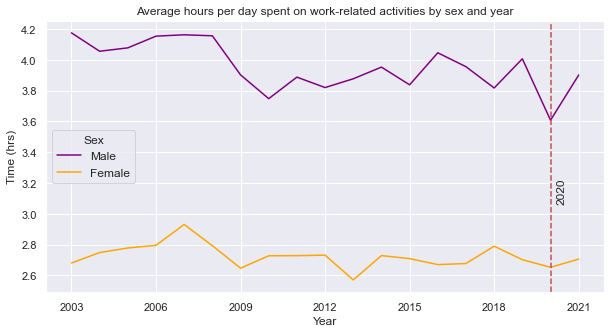

In [12]:
# Work

sns.set_theme()
plt.figure(figsize=(10,5))
pl = sns.lineplot(data = work_by_year, dashes = False,  palette=['purple', 'orange'])
plt.ylabel('Time (hrs)')
plt.xlabel('Year')
plt.title('Average hours per day spent on work-related activities by sex and year')
plt.xticks(np.arange(2003, 2022, 3))
plt.legend(['Male', 'Female'], title = 'Sex', fontsize = 'medium', fancybox=True, loc='center left')
plt.axvline(x = 2020, color = 'r', label = 'axvline - full height', linestyle = 'dashed')
plt.annotate('2020',
            xy=(0.96, 0.3), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels', rotation = 90,
            horizontalalignment='center',
            verticalalignment='center')

Text(-20, 20, '2020')

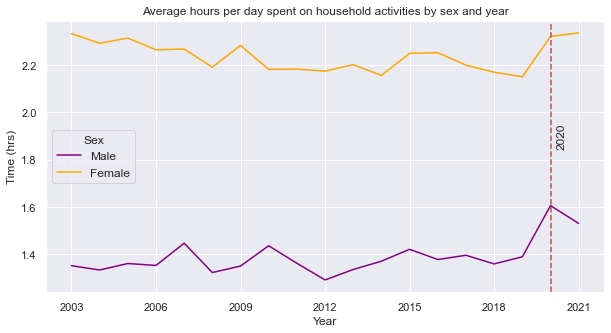

In [13]:
# Household Activities

sns.set_theme()
plt.figure(figsize=(10,5))
pl = sns.lineplot(data = housework_by_year, dashes = False,  palette=['purple', 'orange'])
plt.ylabel('Time (hrs)')
plt.xlabel('Year')
plt.title('Average hours per day spent on household activities by sex and year')
plt.xticks(np.arange(2003, 2022, 3))
plt.legend(['Male', 'Female'], title = 'Sex', fontsize = 'medium', fancybox=True, loc='center left')
COVID_year = 2020
plt.axvline(x = 2020, color = 'r', label = 'axvline - full height', linestyle = 'dashed')
plt.annotate('2020',
            xy=(0.96, 0.5), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels', rotation = 90,
            horizontalalignment='center',
            verticalalignment='center')


Text(-20, 20, '2020')

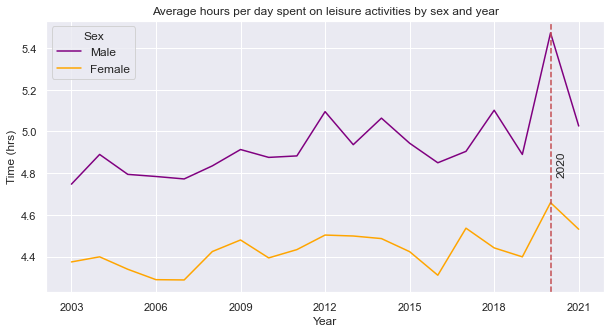

In [14]:
# Leisure

sns.set_theme()
plt.figure(figsize=(10,5))
pl = sns.lineplot(data = leisure_by_year, dashes = False,  palette=['purple', 'orange'])
plt.ylabel('Time (hrs)')
plt.xlabel('Year')
plt.title('Average hours per day spent on leisure activities by sex and year')
plt.xticks(np.arange(2003, 2022, 3))
plt.legend(['Male', 'Female'], title = 'Sex', fontsize = 'medium', fancybox=True, loc='upper left')
plt.axvline(x = 2020, color = 'r', label = 'axvline - full height', linestyle = 'dashed')
plt.annotate('2020',
            xy=(0.96, 0.4), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels', rotation = 90,
            horizontalalignment='center',
            verticalalignment='center')

Text(-20, 20, '2020')

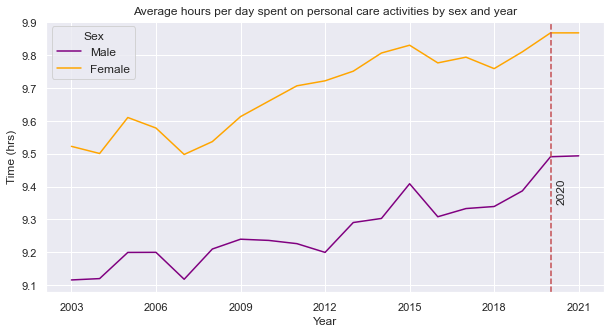

In [15]:
# Personal Care

sns.set_theme()
plt.figure(figsize=(10,5))
pl = sns.lineplot(data = personal_by_year, dashes = False,  palette=['purple', 'orange'])
plt.ylabel('Time (hrs)')
plt.xlabel('Year')
plt.title('Average hours per day spent on personal care activities by sex and year')
plt.xticks(np.arange(2003, 2022, 3))
plt.legend(['Male', 'Female'], title = 'Sex', fontsize = 'medium', fancybox=True, loc='upper left')
plt.axvline(x = 2020, color = 'r', label = 'axvline - full height', linestyle = 'dashed')
plt.annotate('2020',
            xy=(0.96, 0.3), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels', rotation = 90,
            horizontalalignment='center',
            verticalalignment='center')

Text(-20, 20, '2020')

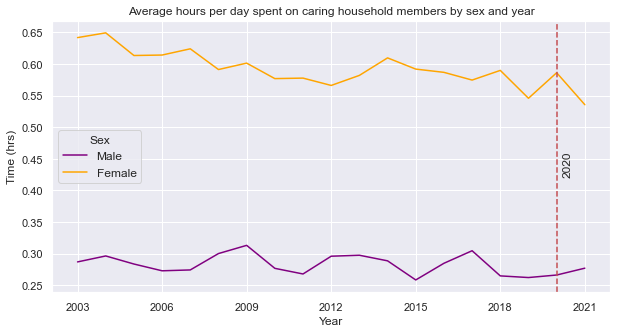

In [16]:
# Caring for Household Members

sns.set_theme()
plt.figure(figsize=(10,5))
pl = sns.lineplot(data = hhcare_by_year, dashes = False,  palette=['purple', 'orange'])
plt.ylabel('Time (hrs)')
plt.xlabel('Year')
plt.title('Average hours per day spent on caring household members by sex and year')
plt.xticks(np.arange(2003, 2022, 3))
plt.legend(['Male', 'Female'], title = 'Sex', fontsize = 'medium', fancybox=True, loc='center left')
plt.axvline(x = 2020, color = 'r', label = 'axvline - full height', linestyle = 'dashed')
plt.annotate('2020',
            xy=(0.96, 0.4), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels', rotation = 90,
            horizontalalignment='center',
            verticalalignment='center')


# Pre-COVID (2003-2019), COVID (2020), and Post-COVID (2021) Averages

In [17]:
# For each activity category:
# Calculate 2003-2019 average time per day
# Calculate 2020 average time per day
# Calculate 2021 average time per day
# Combine dataframes for visualization

In [18]:
# Work & Work-Related Activities

# Calculate 2003-2019 average time per day
pre_covid_work = atus_work[atus_work['TUYEAR'] < 2020]

work_by_year_precovid = (
    pre_covid_work.groupby(
        ['TESEX']
    ).sum()['wgt_act_time'] / pre_covid_work.groupby(
        ['TESEX']
    ).sum()['correct_wgt'] / 60)

# Calculate 2020 average time per day
covid_work = atus_work[atus_work['TUYEAR'] == 2020]

work_by_year_covid = (
    covid_work.groupby(
        ['TESEX']
    ).sum()['wgt_act_time'] / covid_work.groupby(
        ['TESEX']
    ).sum()['correct_wgt'] / 60)

# Calculate 2021 average time per day
post_covid_work = atus_work[atus_work['TUYEAR'] > 2020]

work_by_year_postcovid = (
    post_covid_work.groupby(
        ['TESEX']
    ).sum()['wgt_act_time'] / post_covid_work.groupby(
        ['TESEX']
    ).sum()['correct_wgt'] / 60)

# Combine dataframes
df_work = pd.DataFrame(work_by_year_precovid)
df_work['COVID'] = work_by_year_covid
df_work['post COVID'] = work_by_year_postcovid
df_work = df_work.rename(columns = {0: 'pre COVID'})
df_work = df_work.transpose()
df_work = df_work.iloc[[2,1,0],:]
df_work


TESEX,1,2
post COVID,3.902297,2.705195
COVID,3.608268,2.651982
pre COVID,3.975614,2.728038


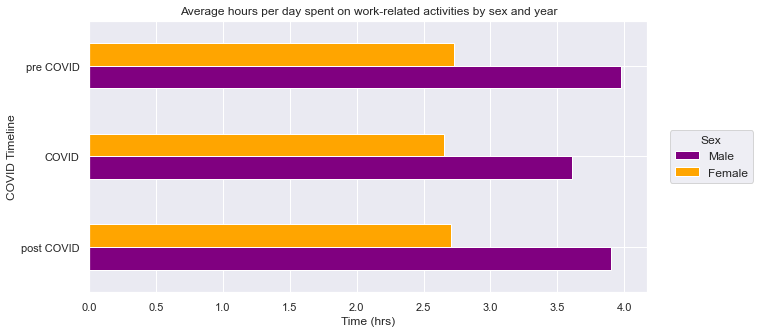

In [19]:
df_work.plot.barh(figsize=(10,5), color = {1: 'purple', 2: 'orange'})
plt.xlabel('Time (hrs)')
plt.ylabel('COVID Timeline')
plt.xlabel('Time (hrs)')
plt.ylabel('COVID Timeline')
plt.title('Average hours per day spent on work-related activities by sex and year')
plt.legend(['Male', 'Female'], title = 'Sex', fontsize = 'medium', fancybox=True, bbox_to_anchor=(1.2, 0.5),loc='right')


In [20]:
# Household Activities

# Calculate 2003-2019 average time per day
pre_covid_housework = atus_housework[atus_housework['TUYEAR'] < 2020]

housework_by_year_precovid = (
    pre_covid_housework.groupby(
        ['TESEX']
    ).sum()['wgt_act_time'] / pre_covid_housework.groupby(
        ['TESEX']
    ).sum()['correct_wgt'] / 60)

covid_housework = atus_housework[atus_housework['TUYEAR'] == 2020]

# Calculate 2020 average time per day
housework_by_year_covid = (
    covid_housework.groupby(
        ['TESEX']
    ).sum()['wgt_act_time'] / covid_housework.groupby(
        ['TESEX']
    ).sum()['correct_wgt'] / 60)

post_covid_housework = atus_housework[atus_housework['TUYEAR'] > 2020]

# Calculate 2021 average time per day
housework_by_year_postcovid = (
    post_covid_housework.groupby(
        ['TESEX']
    ).sum()['wgt_act_time'] / post_covid_housework.groupby(
        ['TESEX']
    ).sum()['correct_wgt'] / 60)

# Combine dataframes
df_housework = pd.DataFrame(housework_by_year_precovid)
df_housework['COVID'] = housework_by_year_covid
df_housework['post COVID'] = housework_by_year_postcovid
df_housework = df_housework.rename(columns = {0: 'pre COVID'})
df_housework = df_housework.transpose()
df_housework = df_housework.iloc[[2,1,0],:]
df_housework


TESEX,1,2
post COVID,1.530127,2.334792
COVID,1.605385,2.319840
pre COVID,1.368539,2.224194


<Figure size 720x360 with 0 Axes>

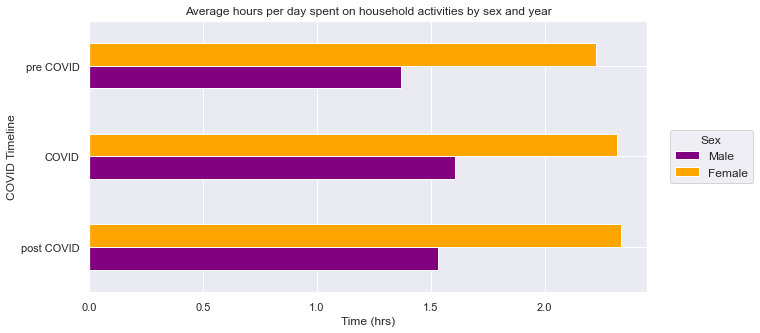

In [21]:
plt.figure(figsize=(10,5))
df_housework.plot.barh(figsize=(10,5), color = {1: 'purple', 2: 'orange'})
plt.xlabel('Time (hrs)')
plt.ylabel('COVID Timeline')
plt.title('Average hours per day spent on household activities by sex and year')
plt.legend(['Male', 'Female'], title = 'Sex', fontsize = 'medium', fancybox=True, bbox_to_anchor=(1.2, 0.5),loc='right')

In [22]:
# Socializing, Relaxing, and Leisure

# Calculate 2003-2019 average time per day
pre_covid_leisure = atus_leisure[atus_leisure['TUYEAR'] < 2020]

leisure_by_year_precovid = (
    pre_covid_leisure.groupby(
        ['TESEX']
    ).sum()['wgt_act_time'] / pre_covid_leisure.groupby(
        ['TESEX']
    ).sum()['correct_wgt'] / 60)

# Calculate 2020 average time per day
covid_leisure = atus_leisure[atus_leisure['TUYEAR'] == 2020]

leisure_by_year_covid = (
    covid_leisure.groupby(
        ['TESEX']
    ).sum()['wgt_act_time'] / covid_leisure.groupby(
        ['TESEX']
    ).sum()['correct_wgt'] / 60)

# Calculate 2021 average time per day
post_covid_leisure = atus_leisure[atus_leisure['TUYEAR'] == 2021]

leisure_by_year_postcovid = (
    post_covid_leisure.groupby(
        ['TESEX']
    ).sum()['wgt_act_time'] / post_covid_leisure.groupby(
        ['TESEX']
    ).sum()['correct_wgt'] / 60)

# Combine dataframes
df_leisure = pd.DataFrame(leisure_by_year_precovid)
df_leisure['COVID'] = leisure_by_year_covid
df_leisure['post COVID'] = leisure_by_year_postcovid
df_leisure = df_leisure.rename(columns = {0: 'pre COVID'})
df_leisure = df_leisure.transpose()
df_leisure = df_leisure.iloc[[2,1,0],:]
df_leisure


TESEX,1,2
post COVID,5.026272,4.530824
COVID,5.473261,4.658513
pre COVID,4.901815,4.414050


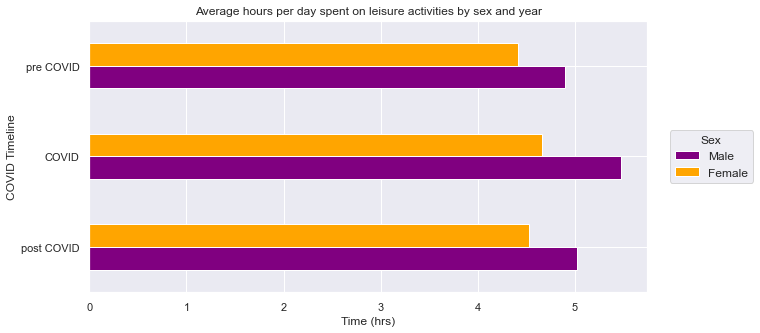

In [23]:
df_leisure.plot.barh(figsize=(10,5), color = {1: 'purple', 2: 'orange'})
plt.xlabel('Time (hrs)')
plt.ylabel('COVID Timeline')
plt.xlabel('Time (hrs)')
plt.ylabel('COVID Timeline')
plt.title('Average hours per day spent on leisure activities by sex and year')
plt.legend(['Male', 'Female'], title = 'Sex', fontsize = 'medium', fancybox=True, bbox_to_anchor=(1.2, 0.5),loc='right')


In [24]:
# Personal Care

# Calculate 2003-2019 average time per day

pre_covid_personal = atus_personal[atus_personal['TUYEAR'] < 2020]

personal_by_year_precovid = (
    pre_covid_personal.groupby(
        ['TESEX']
    ).sum()['wgt_act_time'] / pre_covid_personal.groupby(
        ['TESEX']
    ).sum()['correct_wgt'] / 60)


# Calculate 2020 average time per day
covid_personal = atus_personal[atus_personal['TUYEAR'] == 2020]

personal_by_year_covid = (
    covid_personal.groupby(
        ['TESEX']
    ).sum()['wgt_act_time'] / covid_personal.groupby(
        ['TESEX']
    ).sum()['correct_wgt'] / 60)

# Calculate 2021 average time per day
post_covid_personal = atus_personal[atus_personal['TUYEAR'] > 2020]

personal_by_year_postcovid = (
    post_covid_personal.groupby(
        ['TESEX']
    ).sum()['wgt_act_time'] / post_covid_personal.groupby(
        ['TESEX']
    ).sum()['correct_wgt'] / 60)

# Combine dataframes
df_personal = pd.DataFrame(personal_by_year_precovid)
df_personal['COVID'] = personal_by_year_covid
df_personal['post COVID'] = personal_by_year_postcovid
df_personal = df_personal.rename(columns = {0: 'pre COVID'})
df_personal = df_personal.transpose()
df_personal = df_personal.iloc[[2,1,0],:]
df_personal


TESEX,1,2
post COVID,9.493646,9.868235
COVID,9.490888,9.868154
pre COVID,9.252780,9.680207


<Figure size 720x360 with 0 Axes>

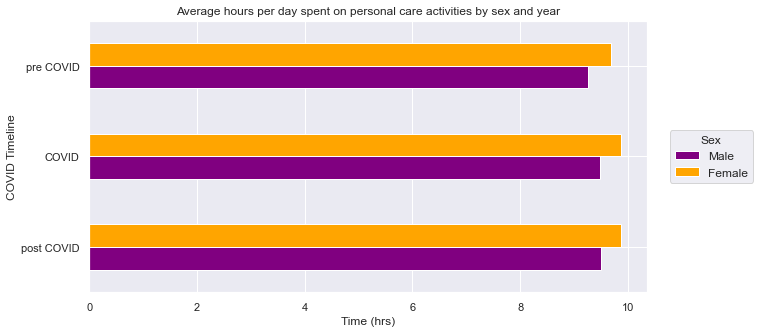

In [25]:
plt.figure(figsize=(10,5))
df_personal.plot.barh(figsize=(10,5), color = {1: 'purple', 2: 'orange'})
plt.xlabel('Time (hrs)')
plt.ylabel('COVID Timeline')
plt.title('Average hours per day spent on personal care activities by sex and year')
plt.legend(['Male', 'Female'], title = 'Sex', fontsize = 'medium', fancybox=True, bbox_to_anchor=(1.2, 0.5),loc='right')


In [26]:
# Caring for Household Members

# Calculate 2003-2019 average time per day
pre_covid_hhcare = atus_hhcare[atus_hhcare['TUYEAR'] < 2020]

hhcare_by_year_precovid = (
    pre_covid_hhcare.groupby(
        ['TESEX']
    ).sum()['wgt_act_time'] / pre_covid_hhcare.groupby(
        ['TESEX']
    ).sum()['correct_wgt'] / 60)

# Calculate 2020 average time per day
covid_hhcare = atus_hhcare[atus_hhcare['TUYEAR'] == 2020]

hhcare_by_year_covid = (
    covid_hhcare.groupby(
        ['TESEX']
    ).sum()['wgt_act_time'] / covid_hhcare.groupby(
        ['TESEX']
    ).sum()['correct_wgt'] / 60)

# Calculate 2021 average time per day
post_covid_hhcare = atus_hhcare[atus_hhcare['TUYEAR'] == 2021]

hhcare_by_year_postcovid = (
    post_covid_hhcare.groupby(
        ['TESEX']
    ).sum()['wgt_act_time'] / post_covid_hhcare.groupby(
        ['TESEX']
    ).sum()['correct_wgt'] / 60)

# Combine dataframes
df_caring = pd.DataFrame(hhcare_by_year_precovid)
df_caring['COVID'] = hhcare_by_year_covid
df_caring['post COVID'] = hhcare_by_year_postcovid
df_caring = df_caring.rename(columns = {0: 'pre COVID'})
df_caring = df_caring.transpose()
df_caring = df_caring.iloc[[2,1,0],:]
df_caring

TESEX,1,2
post COVID,0.277042,0.535657
COVID,0.266220,0.586259
pre COVID,0.283876,0.595412


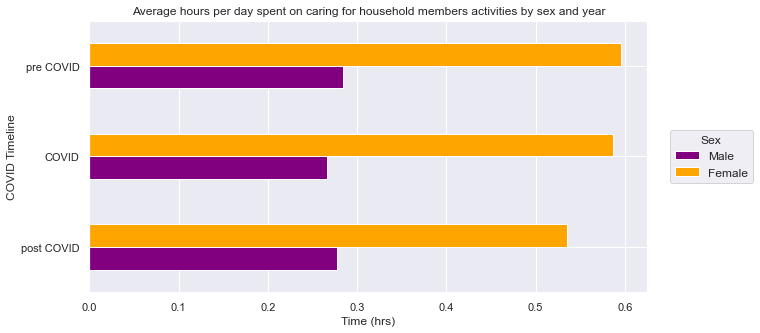

In [27]:
df_caring.plot.barh(figsize=(10,5), color = {1: 'purple', 2: 'orange'})
plt.xlabel('Time (hrs)')
plt.ylabel('COVID Timeline')
plt.xlabel('Time (hrs)')
plt.ylabel('COVID Timeline')
plt.title('Average hours per day spent on caring for household members activities by sex and year')
plt.legend(['Male', 'Female'], title = 'Sex', fontsize = 'medium', fancybox=True, bbox_to_anchor=(1.2, 0.5),loc='right')

# Tables with Activity Differences over Time

In [28]:
# Work & Work-Related Activities
work_by_year['difference'] = diff_col(work_by_year)
work_by_year

TESEX,1,2,difference
TUYEAR,,,
2003,4.176195,2.679770,-1.496425
2004,4.056705,2.747513,-1.309193
2005,4.078586,2.777558,-1.301028
2006,4.154777,2.794634,-1.360143
2007,4.163620,2.930455,-1.233165
2008,4.157078,2.792508,-1.364570
2009,3.903149,2.646302,-1.256847
2010,3.748415,2.726659,-1.021756
2011,3.888344,2.727584,-1.160760


In [29]:
# Household Activities
housework_by_year['difference'] = diff_col(housework_by_year)
housework_by_year

TESEX,1,2,difference
TUYEAR,,,
2003,1.351769,2.331648,0.979879
2004,1.333693,2.291036,0.957344
2005,1.360916,2.312626,0.951710
2006,1.352799,2.263331,0.910532
2007,1.446724,2.266536,0.819812
2008,1.322877,2.189807,0.866930
2009,1.350205,2.281668,0.931463
2010,1.435982,2.180629,0.744647
2011,1.361963,2.181588,0.819625


In [30]:
# Socializing, Relaxing, and Leisure

leisure_by_year['difference'] = diff_col(leisure_by_year)
leisure_by_year

TESEX,1,2,difference
TUYEAR,,,
2003,4.747215,4.373964,-0.373251
2004,4.889786,4.398445,-0.491341
2005,4.794105,4.338679,-0.455426
2006,4.783969,4.288801,-0.495168
2007,4.772206,4.287491,-0.484715
2008,4.834978,4.423874,-0.411105
2009,4.913361,4.479333,-0.434028
2010,4.875598,4.393284,-0.482314
2011,4.882745,4.433078,-0.449667


In [31]:
# Personal Care
personal_by_year['difference'] = diff_col(personal_by_year)
personal_by_year

TESEX,1,2,difference
TUYEAR,,,
2003,9.115615,9.522518,0.406904
2004,9.119711,9.500778,0.381066
2005,9.199409,9.610402,0.410994
2006,9.199733,9.578316,0.378583
2007,9.117709,9.497846,0.380137
2008,9.209836,9.536986,0.327150
2009,9.239691,9.613096,0.373405
2010,9.236050,9.660125,0.424075
2011,9.226177,9.706944,0.480768


In [32]:
# Caring for Household Members
hhcare_by_year['difference'] = diff_col(hhcare_by_year)
hhcare_by_year

TESEX,1,2,difference
TUYEAR,,,
2003,0.286969,0.641842,0.354873
2004,0.296390,0.649358,0.352968
2005,0.283622,0.613519,0.329898
2006,0.272903,0.614261,0.341358
2007,0.274268,0.624109,0.349841
2008,0.300181,0.591327,0.291145
2009,0.313157,0.601470,0.288314
2010,0.276797,0.576970,0.300172
2011,0.267874,0.577758,0.309884
